## Import Library

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from google.colab import files

## Upload the Dataset

In [ ]:
upload_dataset = files.upload()

Saving rating.csv to rating.csv


In [ ]:
rating = pd.read_csv('rating.csv')

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10105 entries, 0 to 10104
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   user_id      10105 non-null  int64
 1   tourism_id   10105 non-null  int64
 2   user_rating  10105 non-null  int64
dtypes: int64(3)
memory usage: 237.0 KB


In [ ]:
rating.shape

(10105, 3)

In [ ]:
rating.sample(10)

,user_id,tourism_id,user_rating
862,41,68,4
4346,9,343,3
7640,195,597,4
9332,73,726,3
3003,5,238,2
5300,113,420,1
6404,123,502,2
3637,150,286,1
1446,188,113,5
5636,184,448,3


## Preparing Data

In [ ]:
df = rating.copy()
df.head()

,user_id,tourism_id,user_rating
0,46,1,5
1,170,1,5
2,51,1,4
3,9,1,4
4,52,1,3


### Encoding

In [ ]:
def transmute_column(column_name, dataset=df):
    unique_elements = dataset[column_name].unique().tolist()
    element_to_index = {element: index for index, element in enumerate(unique_elements)}
    index_to_element = {index: element for index, element in enumerate(unique_elements)}
    return element_to_index, index_to_element

In [ ]:
user_alias_to_code, code_to_user_alias = transmute_column('user_id')
df['user'] = df['user_id'].map(user_alias_to_code)
place_to_code, code_to_place = transmute_column('tourism_id')
df['place'] = df['tourism_id'].map(place_to_code)

In [ ]:
total_users = len(user_alias_to_code)
total_places = len(place_to_code)
df['user_rating'] = df['user_rating'].astype(np.float32)
lowest_rating, highest_rating = df['user_rating'].min(), df['user_rating'].max()
print(f'Number of Users: {total_users}, Number of Places: {total_places}, Min Rating: {lowest_rating}, Max Rating: {highest_rating}')

Number of Users: 200, Number of Places: 786, Min Rating: 1.0, Max Rating: 5.0


In [ ]:
df = df.sample(frac=1, random_state=42)
df.sample(5)

,user_id,tourism_id,user_rating,user,place
2919,161,231,5.0,34,230
8874,67,690,2.0,88,689
6756,88,528,3.0,143,527
1585,111,124,5.0,105,123
3939,58,311,5.0,32,310


## Machine Learning Modeling

### Split train and test data

In [ ]:
features = df[['user', 'place']].values
targets = df['user_rating'].apply(lambda rating: (rating - lowest_rating) / (highest_rating - lowest_rating)).values

training_size = int(0.8 * len(df))
features_train, features_val = features[:training_size], features[training_size:]
targets_train, targets_val = targets[:training_size], targets[training_size:]

### Function Initialization

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import json

class TourifyRecommender(tf.keras.Model):
    def __init__(self, total_users, total_places, embedding_dim):
        super(TourifyRecommender, self).__init__()
        self.total_users = total_users
        self.total_places = total_places
        self.embedding_dim = embedding_dim
        self.user_embedding = layers.Embedding(
            total_users,
            embedding_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(total_users, 1)
        self.place_embedding = layers.Embedding(
            total_places,
            embedding_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(1e-6)
        )
        self.place_bias = layers.Embedding(total_places, 1)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(64, activation='relu')
        self.output_layer = layers.Dense(total_places, activation='softmax')

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        dot_user_place = tf.tensordot(user_vector, place_vector, 2)

        x = dot_user_place + user_bias + place_bias

        return tf.nn.sigmoid(x)

    def to_json(self):
        weights = {
            'user_embedding': self.user_embedding.get_weights()[0].tolist(),
            'user_bias': self.user_bias.get_weights()[0].tolist(),
            'place_embedding': self.place_embedding.get_weights()[0].tolist(),
            'place_bias': self.place_bias.get_weights()[0].tolist()
        }
        model_config = {
            'total_users': self.total_users,
            'total_places': self.total_places,
            'embedding_dim': self.embedding_dim,
            'weights': weights
        }
        return json.dumps(model_config)

    @classmethod
    def from_json(cls, json_str):
        model_config = json.loads(json_str)
        model = cls(
            model_config['total_users'],
            model_config['total_places'],
            model_config['embedding_dim']
        )
        model.build(input_shape=(None, 2))
        model.user_embedding.set_weights([tf.constant(model_config['weights']['user_embedding'])])
        model.user_bias.set_weights([tf.constant(model_config['weights']['user_bias'])])
        model.place_embedding.set_weights([tf.constant(model_config['weights']['place_embedding'])])
        model.place_bias.set_weights([tf.constant(model_config['weights']['place_bias'])])
        return model

In [ ]:
model = TourifyRecommender(total_users, total_places, 50)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(
    x = features_train,
    y = targets_train,
    epochs = 100,
    validation_data = (features_val, targets_val)
)

Epoch 1/100
253/253 [==============================] - 2s 3ms/step - loss: 0.1270 - root_mean_squared_error: 0.3561 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3543
Epoch 2/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1260 - root_mean_squared_error: 0.3547 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3543
Epoch 3/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1258 - root_mean_squared_error: 0.3543 - val_loss: 0.1253 - val_root_mean_squared_error: 0.3538
Epoch 4/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1253 - root_mean_squared_error: 0.3537 - val_loss: 0.1263 - val_root_mean_squared_error: 0.3551
Epoch 5/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1253 - root_mean_squared_error: 0.3538 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3543
Epoch 6/100
253/253 [==============================] - 1s 2ms/step - loss: 0.1243 - root_mean_squared_error: 0.3522 - val_loss: 0.1259 

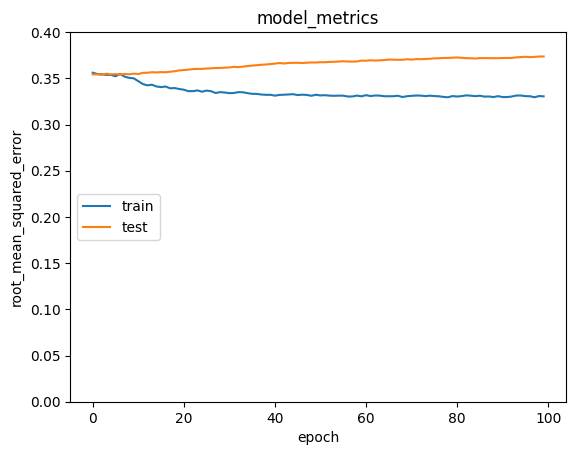

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

### Saving Model

In [ ]:
# Simpan model ke dalam format JSON
model_json = model.to_json()
with open('TourifyRecommender_model.json', 'w') as json_file:
    json_file.write(model_json)